**Note**: This notebook continues from the previous notebook on EDA and Feature Engineering. Most of this Notebook was prepared with Google Colab. The URLs to file locations on Google Drive can be replaced by the local file path. i.e. `/content/drive/MyDrive/output/train_complete.csv` should be substituted with `../output/train_complete.csv`

Please note that some files were considered too large for Git and are not available.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
tf.config.run_functions_eagerly(True) # to suppress warnings
tf.data.experimental.enable_debug_mode()


# Importing the pretrained Universal Sentence Encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True,
                                        name="universal_sentence_encoder")

#### Reloading files

In [3]:
# train and test df with added features
train_df = pd.read_csv('/content/drive/MyDrive/output/train_complete.csv')
test_df = pd.read_csv('/content/drive/MyDrive/output/test_complete.csv')
# preprocessed texts (question1 and question2)
preprocessed_train_q1 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_train_1.csv',
                                    header=None).fillna("")
preprocessed_train_q2 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_train_2.csv',
                                    header=None).fillna("")
preprocessed_test_q1 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_test_1.csv',
                                   header=None).fillna("")
preprocessed_test_q1 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_test_2.csv',
                                   header=None).fillna("")
y_train = train_df['is_duplicate']
y_test = test_df['is_duplicate']

# train_df = pd.read_csv('/content/drive/MyDrive/output/train_df.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/output/test_df.csv')

# train_q1 = train_df['question1'].fillna("")
# train_q2 = train_df['question2'].fillna("")

# test_q1 = test_df['question1'].fillna("")
# test_q2 = test_df['question2'].fillna("")



# Managing the Class inbalance.

In [ ]:
display(y_train.value_counts())
print(f"We will need {y_train.value_counts()[0]-y_train.value_counts()[1]} more 1 datapoints")

0    204006
1    119424
Name: is_duplicate, dtype: int64

We will need 84582 more 1 datapoints


In [ ]:
filter = y_train == 1
y_train_ = y_train[filter].sample(n=84582, random_state=88)

train_df_ = train_df.loc[y_train_.index]
y_train_ = pd.concat([y_train_, y_train])
train_df_ = pd.concat([train_df_, train_df])
y_train_.value_counts()

1    288588
0    204006
Name: is_duplicate, dtype: int64

In [ ]:
preprocessed_train_q1 = preprocessed_train_q1.iloc[y_train_.index]
preprocessed_train_q2 = preprocessed_train_q2.iloc[y_train_.index]
y_train = y_train_.copy()
train_df = train_df_.copy()
len(y_train), len(train_df), len(preprocessed_train_q1), len(preprocessed_train_q2)

(492594, 562634, 492594, 492594)

# Modeling - Deep Learning

Deep Learning experiments start here. The strategy is to start with a simple model and one feature, and build up on from there.

## Model 1- with Similiarty (USE Embedding parameter)

This is our base DL model. It simply passes through the feature Similarity which is supposed to represent the semantic difference between the two questions, into a simple neural network with 1 4-node hidden layer. Similarity was chosen based on the result of its p-value (<0.05) discovered in the Machine Learning experiments.


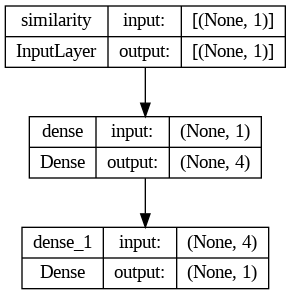

In [4]:
tf.random.set_seed(88) 
similarity_inputs = layers.Input(shape=(1,), name='similarity')
hidden = layers.Dense(4, activation='relu')(similarity_inputs)

output_layer = layers.Dense(1, activation="sigmoid")(hidden)


model = tf.keras.Model(inputs=similarity_inputs,
                         outputs=output_layer,
                         name="similarity_model")

plot_model(model, show_shapes=True)

### Building the Dataset

The csvs datasets will be converted to the Tensorflow's `.dataset` class, which will optimize the training process and reduce the memory load on the processors.

From the website:

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

The `tf.data.Dataset API` supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.
Iteration happens in a streaming fashion, **so the full dataset does not need to fit into memory**.




In [5]:
# the X for this model is just the 'similarity' parameter
del X # clear the cache
X = train_df['similarity']
y = train_df['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=88)

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# convert to Tensor batch datasets to optimize performance 
train_data = tf.data.Dataset.from_tensor_slices((X_train)) # make data
train_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) # combine data and labels

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps test data
test_data = tf.data.Dataset.from_tensor_slices((X_test))
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Validation set from the hold out####
X_valid = test_df['similarity']
y_valid = test_df['is_duplicate']

valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
valid_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))
# Prefetch and batch valid data
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



### Model Training

In [ ]:
# define a callback function to stop training if it's not improving
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
# use another callback to save the best version of the model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='output/model1',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model.fit(train_dataset.repeat(),
                    steps_per_epoch=int(0.02 * len(train_dataset)),
                    epochs=15,
                    callbacks=[callback, model_checkpoint_callback],
                    validation_data=test_dataset,
                    validation_steps=int(0.02 * len(test_dataset)))

Epoch 1/15
229/229 [==============================] - 8s 31ms/step - loss: 0.6625 - accuracy: 0.5796 - val_loss: 0.6475 - val_accuracy: 0.6475
Epoch 2/15
229/229 [==============================] - 7s 31ms/step - loss: 0.6285 - accuracy: 0.7164 - val_loss: 0.6145 - val_accuracy: 0.7212
Epoch 3/15
229/229 [==============================] - 7s 30ms/step - loss: 0.5996 - accuracy: 0.7354 - val_loss: 0.5882 - val_accuracy: 0.7412
Epoch 4/15
229/229 [==============================] - 7s 31ms/step - loss: 0.5719 - accuracy: 0.7473 - val_loss: 0.5682 - val_accuracy: 0.7350
Epoch 5/15
229/229 [==============================] - 7s 29ms/step - loss: 0.5543 - accuracy: 0.7485 - val_loss: 0.5514 - val_accuracy: 0.7412
Epoch 6/15
229/229 [==============================] - 7s 32ms/step - loss: 0.5357 - accuracy: 0.7530 - val_loss: 0.5404 - val_accuracy: 0.7412
Epoch 7/15
229/229 [==============================] - 7s 29ms/step - loss: 0.5357 - accuracy: 0.7467 - val_loss: 0.5322 - val_accuracy: 0.7337

## Model 2 - Derived features only

This model passes all the generated features (similarity, cosine_distance and common_words) into a slightly more sophisticated neural network. 

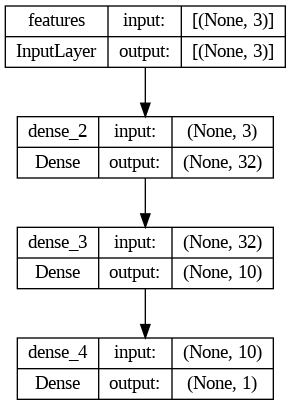

In [22]:
tf.random.set_seed(88)
# diff_common inputs/models
features_inputs = layers.Input(shape=(3,), name='features')
features_hidden = layers.Dense(32, activation='relu')(features_inputs)
features_output = layers.Dense(10, activation='relu')(features_hidden)

output_layer = layers.Dense(1, activation="sigmoid")(features_output)

# 5. Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=features_inputs,
                         outputs=output_layer,
                         name="features_model")


plot_model(model_2, show_shapes=True)

### Building the Dataset

In [23]:
del X # clear the previous values
del y # clear the previous values

X = train_df[['similarity', 'common_words', 'cosine_distance']]
y = train_df['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=88)
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# convert to Tensor batch datasets to optimize performance 
train_data = tf.data.Dataset.from_tensor_slices((X_train)) # make data
train_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) # combine data and labels

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps for test data
test_data = tf.data.Dataset.from_tensor_slices((X_test))
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
     
# repeat same steps for validation data
del X_valid # clear the previous values
X_valid = test_df[['similarity', 'common_words', 'cosine_distance']]
y_valid = test_df['is_duplicate']

valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
valid_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))
# Prefetch and batch test data
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



# Check shape
# train_dataset, test_dataset



### Model Training

In [ ]:
# define a callback function to stop training if it's not improving
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
# use another callback to save the best version of the model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='output2/model2',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# note ran this 15 times because it looked like val_accuracy was still improving
history_2 = model_2.fit(train_dataset.repeat(),
                    steps_per_epoch=int(0.02 * len(train_dataset)),
                    epochs=5,
                    callbacks=[callback, model_checkpoint_callback],
                    validation_data=test_dataset,
                    validation_steps=int(0.02 * len(test_dataset)))

Epoch 1/5
229/229 [==============================] - 9s 41ms/step - loss: 0.4978 - accuracy: 0.7478 - val_loss: 0.5095 - val_accuracy: 0.7487
Epoch 2/5
229/229 [==============================] - 14s 63ms/step - loss: 0.5050 - accuracy: 0.7421 - val_loss: 0.5070 - val_accuracy: 0.7412
Epoch 3/5
229/229 [==============================] - 11s 49ms/step - loss: 0.5005 - accuracy: 0.7439 - val_loss: 0.5078 - val_accuracy: 0.7400
Epoch 4/5
229/229 [==============================] - 9s 37ms/step - loss: 0.4977 - accuracy: 0.7488 - val_loss: 0.5069 - val_accuracy: 0.7375
Epoch 5/5
229/229 [==============================] - 9s 39ms/step - loss: 0.4956 - accuracy: 0.7523 - val_loss: 0.5068 - val_accuracy: 0.7375


## Model 3 - Questions 1 & 2 passing through the USE only

In order to not pass `question 1` and `question 2` through the USE embedder at the same time, and therefore distorting the disparity of their values, we will pass them through the embedding and dense output layers separately then combine them with `layers.Concatenate` before passing through a simple 3-layer dense network. 

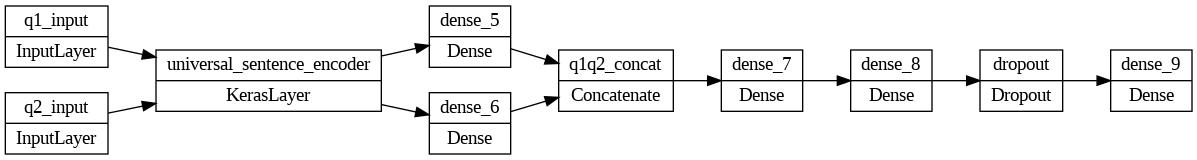

In [25]:
tf.random.set_seed(88)

# Q1 input/model
q1_inputs = layers.Input(shape=[], dtype=tf.string, name='q1_input')
q1_embedding = tf_hub_embedding_layer(q1_inputs)
q1_output = layers.Dense(128, activation='relu')(q1_embedding)

q1_model = tf.keras.Model(inputs=q1_inputs, 
                          outputs=q1_output)

# Q2 input/model
q2_inputs = layers.Input(shape=[], dtype=tf.string, name='q2_input')
q2_embedding = tf_hub_embedding_layer(q2_inputs)
q2_output = layers.Dense(128, activation='relu')(q2_embedding)

q2_model = tf.keras.Model(inputs=q2_inputs, 
                          outputs=q2_output)

# Concatenate Q1 and Q2 model outputs 
q1q2_concat = layers.Concatenate(name="q1q2_concat")([q1_model.output,
                                                             q2_model.output])

# Create output layers 
combined_dense = layers.Dense(128, activation="relu")(q1q2_concat) 
hidden_dense = layers.Dense(128, activation="relu")(combined_dense) 
final_dropout = layers.Dropout(0.5)(hidden_dense)
output_layer = layers.Dense(1, activation="sigmoid")(final_dropout)

# 5. Construct model with char and token inputs
model_3 = tf.keras.Model(inputs=[q1_model.input, 
                                 q2_model.input],
                         outputs=output_layer,
                         name="q1q2_use")


plot_model(model_3, rankdir='LR')

### Building The Dataset

In [27]:
del X # clear the previous values
del y # clear the previous values
X['q1'] = preprocessed_train_q1 
X['q2'] = preprocessed_train_q2

X = train_df[['question1', 'question2']] # these are the preprocessed train features 



y = train_df['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=88)

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Combine chars and tokens into a dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train['question1'].tolist(), 
                                                 X_train['question2'].tolist())) # make data
train_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) # combine data and labels

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
test_data = tf.data.Dataset.from_tensor_slices((X_test['question1'].tolist(), 
                                                 X_test['question2'].tolist()))
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# repeat same steps for validation data
del X_valid
del y_valid
X_valid = test_df[['question1', 'question2']]
y_valid = test_df['is_duplicate']

valid_data = tf.data.Dataset.from_tensor_slices((X_valid['question1'].tolist(), 
                                                 X_valid['question2'].tolist()))
valid_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))
# Prefetch and batch test data
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


     

# Check shape
train_dataset, test_dataset

### Model Training

In [ ]:
# use another callback to save the best version of the model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='output3/model3',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_dataset,
                    steps_per_epoch=int(0.02 * len(train_dataset)),
                    epochs=15,
                    callbacks=[callback, model_checkpoint_callback],
                    validation_data=test_dataset,
                    validation_steps=int(0.02 * len(test_dataset)))

Epoch 1/15
229/229 [==============================] - 207s 889ms/step - loss: 0.6197 - accuracy: 0.6547 - val_loss: 0.6000 - val_accuracy: 0.6988
Epoch 2/15
229/229 [==============================] - 177s 771ms/step - loss: 0.5712 - accuracy: 0.7126 - val_loss: 0.5655 - val_accuracy: 0.6875
Epoch 3/15
229/229 [==============================] - 210s 914ms/step - loss: 0.5572 - accuracy: 0.7160 - val_loss: 0.5682 - val_accuracy: 0.7000
Epoch 4/15
229/229 [==============================] - 198s 864ms/step - loss: 0.5351 - accuracy: 0.7321 - val_loss: 0.5642 - val_accuracy: 0.7025
Epoch 5/15
229/229 [==============================] - 174s 761ms/step - loss: 0.5374 - accuracy: 0.7290 - val_loss: 0.5447 - val_accuracy: 0.7287
Epoch 6/15
229/229 [==============================] - 143s 626ms/step - loss: 0.5285 - accuracy: 0.7369 - val_loss: 0.5530 - val_accuracy: 0.7188
Epoch 7/15
229/229 [==============================] - 144s 629ms/step - loss: 0.5272 - accuracy: 0.7430 - val_loss: 0.5343 -

## Model 4 - Combining all the Features

The structure of this model was inspired by the Deep Learning model used in this paper (https://arxiv.org/abs/1710.06071) which was used for sequential sentence classification in medical abstracts. It involved building sub-models for text-level and character-level encodding which was concatenated before being passed through dense layers and output. 

My model passed the sentences through the Universal Sentence Encoder as a sub-model, then passed the engineered features (`Similarity`, also calculated from the Universal Sentence Encoder, `Common Words` ratio, and `Cosine Distance` from `doc2vec` document-level embedding through another dense sub-model. Then these outputs are concatenated and passed through a few more hidden layers then output.

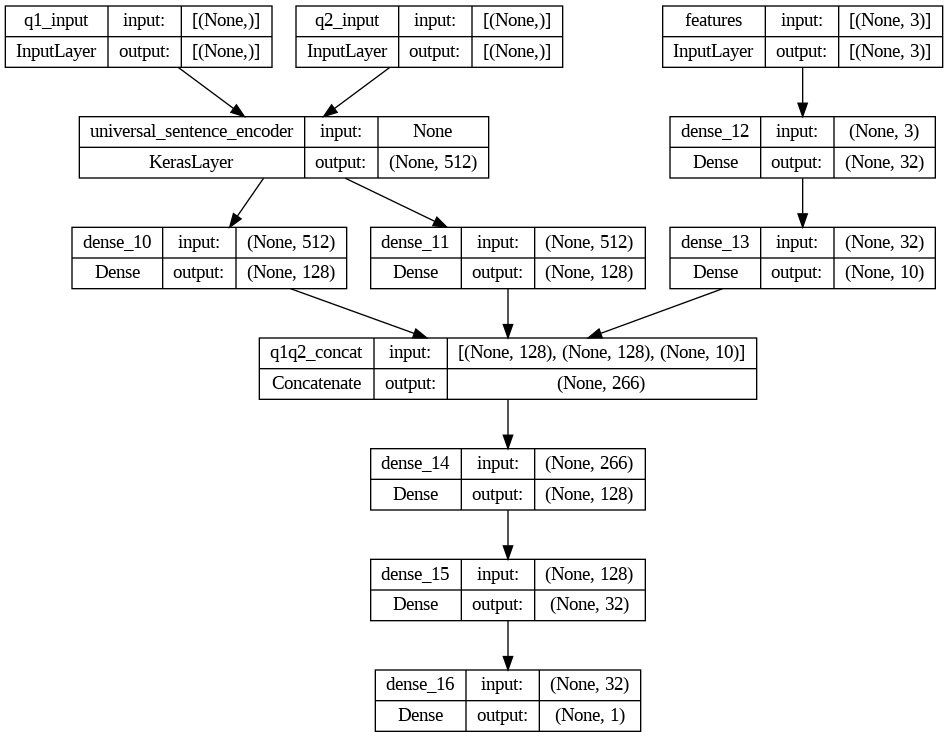

In [29]:
# Q1 input/model
q1_input = layers.Input(shape=[], dtype=tf.string, name='q1_input')
q1_embedding = tf_hub_embedding_layer(q1_input)
q1_output = layers.Dense(128, activation='relu')(q1_embedding)

q1_model = tf.keras.Model(inputs=q1_input, 
                          outputs=q1_output)

# Q2 input/model
q2_input = layers.Input(shape=[], dtype=tf.string, name='q2_input')
q2_embedding = tf_hub_embedding_layer(q2_input)
q2_output = layers.Dense(128, activation='relu')(q2_embedding)

q2_model = tf.keras.Model(inputs=q2_input, 
                          outputs=q2_output)


# features input/model
features_input = layers.Input(shape=(3,), name='features')
features_hidden = layers.Dense(32, activation='relu')(features_input)
features_output = layers.Dense(10, activation='relu')(features_hidden)


features_model = tf.keras.Model(inputs=features_input, 
                                   outputs=features_output)

# Concatenate Q1, Q2 and features inputs 
q1q2_concat = layers.Concatenate(name="q1q2_concat")([q1_model.output,
                                                             q2_model.output,
                                                             features_model.output])

# Create output layers 

combined_dense = layers.Dense(128, activation="relu")(q1q2_concat) 
inner_dense = layers.Dense(32, activation='relu')(combined_dense)
output_layer = layers.Dense(1, activation="sigmoid")(inner_dense)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[q1_model.input, 
                                 q2_model.input,
                                 features_model.input],
                         outputs=output_layer,
                         name="all_features")

plot_model(model_4, show_shapes=True)


### Building the Dataset

In [31]:
del X # clear the cache

X = train_df[['similarity', 'common_words', 'cosine_distance', 
              'question1', 'question2']]
y = train_df['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=88)
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# the derived features
train_features = X_train[['similarity', 'common_words', 'cosine_distance']]
test_features = X_test[['similarity', 'common_words', 'cosine_distance']]

# squeezing to avoid the shape error
train_features_tensor = np.squeeze(train_features)
test_features_tensor = np.squeeze(test_features)

# Combine features into a dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train['question1'].tolist(), 
                                                 X_train['question2'].tolist(),
                                                 train_features_tensor)) # make data
train_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) # combine data and labels

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps for test(validation) data
test_data = tf.data.Dataset.from_tensor_slices((X_test['question1'].tolist(), 
                                                 X_test['question2'].tolist(),
                                                 test_features_tensor))
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# repeat same steps for validation data
del X_valid
del y_valid
X_valid = test_df[['similarity', 'common_words', 'cosine_distance', 
              'question1', 'question2']]
y_valid = test_df['is_duplicate']

# the derived features
valid_features = X_valid[['similarity', 'common_words', 'cosine_distance']]
# squeezing to avoid the shape error
valid_features_tensor = np.squeeze(valid_features)



valid_data = tf.data.Dataset.from_tensor_slices((X_valid['question1'].tolist(), 
                                                 X_valid['question2'].tolist(),
                                                 valid_features_tensor))
valid_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))
# Prefetch and batch test data
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)





### Model Training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='output4/model4',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# actually trained for 20 epochs as the val accuracy was 
# increasing before training data started overfitting
history_4 = model_4.fit(train_dataset.repeat(),
                    steps_per_epoch=int(0.02 * len(train_dataset)),
                    epochs=1,
                    callbacks=[callback, model_checkpoint_callback],
                    validation_data=test_dataset,
                    validation_steps=int(0.02 * len(test_dataset)))

242/242 [==============================] - 237s 969ms/step - loss: 0.1617 - accuracy: 0.9357 - val_loss: 0.5396 - val_accuracy: 0.8177


## Model 5 - More layers and dropout to Model 4


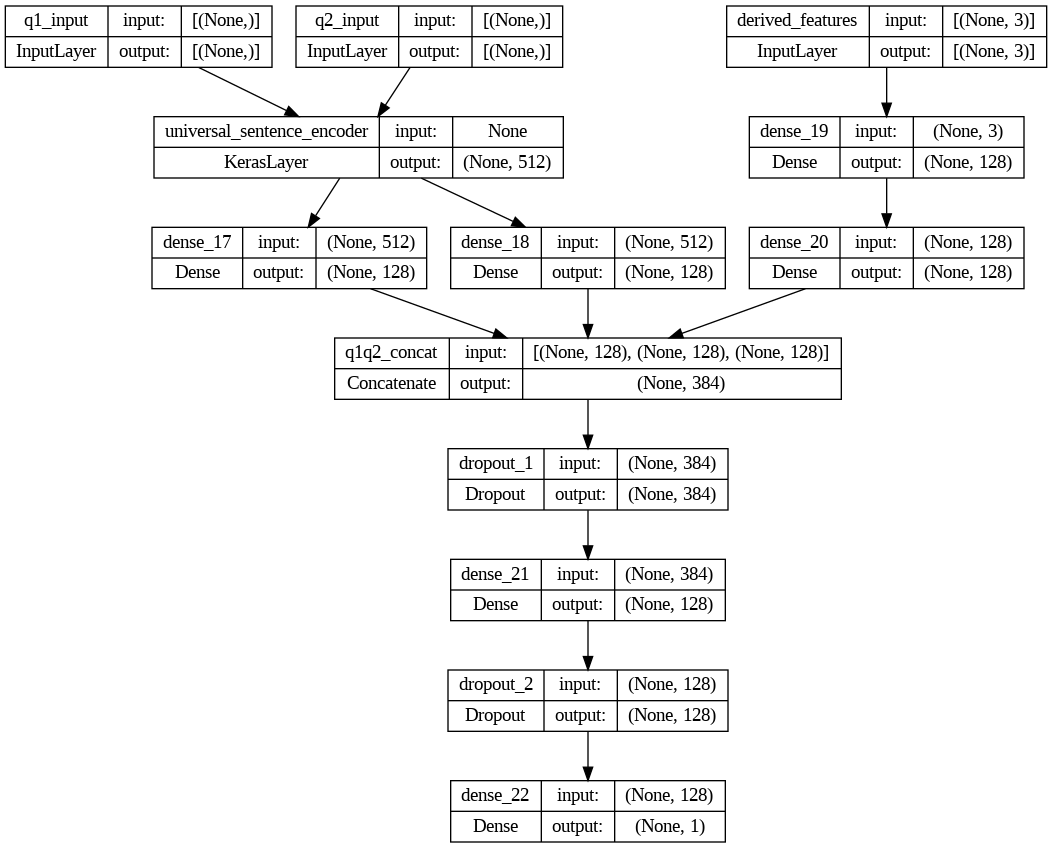

In [33]:
# Q1 inputs/model
q1_input = layers.Input(shape=[], dtype=tf.string, name='q1_input')
q1_embedding = tf_hub_embedding_layer(q1_input)
q1_output = layers.Dense(128, activation='relu')(q1_embedding)

q1_model = tf.keras.Model(inputs=q1_input, 
                          outputs=q1_output)

# Q2 inputs/models
q2_input = layers.Input(shape=[], dtype=tf.string, name='q2_input')
q2_embedding = tf_hub_embedding_layer(q2_input)
q2_output = layers.Dense(128, activation='relu')(q2_embedding)

q2_model = tf.keras.Model(inputs=q2_input, 
                          outputs=q2_output)

# diff_common inputs/models
features_inputs = layers.Input(shape=(3,), name='derived_features')
hidden_layer = layers.Dense(128, activation='relu')(features_inputs)
features_output = layers.Dense(128, activation='relu')(hidden_layer)


features_model = tf.keras.Model(inputs=features_inputs, 
                                   outputs=features_output)

# Concatenate Q1 and Q2 inputs 
q1q2_concat = layers.Concatenate(name="q1q2_concat")([q1_model.output,
                                                             q2_model.output,
                                                             features_model.output])

# Create output layers 
combined_dropout = layers.Dropout(0.5)(q1q2_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1, activation="sigmoid")(final_dropout)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[q1_model.input, 
                                 q2_model.input,
                                 features_model.input],
                         outputs=output_layer,
                         name="q1q2_and_features_complex_version")


plot_model(model_5, show_shapes=True)

### Building the Dataset

In [34]:
# This is the same dataset as above, but repeated here for consistency.

del X

X = train_df[['similarity', 'common_words', 'cosine_distance', 
              'question1', 'question2']]
y = train_df['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=88)
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# the derived features
train_features = X_train[['similarity', 'common_words', 'cosine_distance']]
test_features = X_test[['similarity', 'common_words', 'cosine_distance']]

# squeezing to avoid the shape error
train_features_tensor = np.squeeze(train_features)
test_features_tensor = np.squeeze(test_features)

# Combine features into a dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train['question1'].tolist(), 
                                                 X_train['question2'].tolist(),
                                                 train_features_tensor)) # make data
train_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) # combine data and labels

# Prefetch and batch train data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps for test(validation) data
test_data = tf.data.Dataset.from_tensor_slices((X_test['question1'].tolist(), 
                                                 X_test['question2'].tolist(),
                                                 test_features_tensor))
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))
# Prefetch and batch test data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# repeat same steps for validation data
del X_valid
del y_valid
X_valid = test_df[['similarity', 'common_words', 'cosine_distance', 
              'question1', 'question2']]
y_valid = test_df['is_duplicate']

# the derived features
valid_features = X_valid[['similarity', 'common_words', 'cosine_distance']]
# squeezing to avoid the shape error
valid_features_tensor = np.squeeze(valid_features)



valid_data = tf.data.Dataset.from_tensor_slices((X_valid['question1'].tolist(), 
                                                 X_valid['question2'].tolist(),
                                                 valid_features_tensor))
valid_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))
# Prefetch and batch test data
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)





### Model Training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='output5/model5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5 = model_5.fit(train_dataset.repeat(),
                    steps_per_epoch=int(0.01 * len(train_dataset)),
                    epochs=10,
                    callbacks=[callback, model_checkpoint_callback],
                    validation_data=test_dataset,
                    validation_steps=int(0.01 * len(test_dataset)))

Epoch 1/10
121/121 [==============================] - 141s 1s/step - loss: 0.2230 - accuracy: 0.9117 - val_loss: 0.8835 - val_accuracy: 0.7708
Epoch 2/10
121/121 [==============================] - 119s 986ms/step - loss: 0.0665 - accuracy: 0.9780 - val_loss: 0.8819 - val_accuracy: 0.7865
Epoch 3/10
121/121 [==============================] - 153s 1s/step - loss: 0.1369 - accuracy: 0.9548 - val_loss: 0.6160 - val_accuracy: 0.8021
Epoch 4/10
121/121 [==============================] - 147s 1s/step - loss: 0.1209 - accuracy: 0.9540 - val_loss: 0.5138 - val_accuracy: 0.8229
Epoch 5/10
121/121 [==============================] - 77s 638ms/step - loss: 0.1031 - accuracy: 0.9613 - val_loss: 0.8632 - val_accuracy: 0.7760
Epoch 6/10
121/121 [==============================] - 76s 626ms/step - loss: 0.0748 - accuracy: 0.9739 - val_loss: 0.6724 - val_accuracy: 0.8177


# Evaluations

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(model, X_test, y_test):
  """function to return scores"""
  y_pred = tf.round(model.predict(X_test))
  accuracy = accuracy_score(y_test, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
  model_results = {"accuracy": accuracy,
                  "precision": precision,
                  "recall": recall,
                  "f1": f1}
  return model_results, y_pred

Note that to calculate results, we have to re-run the **Building The Dataset** cells for each Model header *before* runnning its corresponding `result` cell because the names of `valid_dataset` are reused. (It might also save time to comment out the code for the train and testing datasets and start from `del X_valid`.)


In [20]:
model.load_weights('/content/drive/MyDrive/output/models/output/model1')
result1 = calculate_results(model, valid_dataset, y_valid)

2527/2527 [==============================] - 13s 5ms/step


In [24]:
# remember to re-run 'building the dataset'
model_2.load_weights('/content/drive/MyDrive/output/models/output2/model2')
result2 = calculate_results(model_2, valid_dataset, y_valid)
result2

2527/2527 [==============================] - 9s 4ms/step


({'accuracy': 0.7167963194281262,
  'precision': 0.7716899572857512,
  'recall': 0.7167963194281262,
  'f1': 0.7210268785891565},
 <tf.Tensor: shape=(80857, 1), dtype=float32, numpy=
 array([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]], dtype=float32)>)

In [28]:
# remember to re-run 'building the dataset'
model_3.load_weights('/content/drive/MyDrive/output/models/output3/model3')
result3 = calculate_results(model_3, valid_dataset, y_valid)

2527/2527 [==============================] - 86s 33ms/step


In [32]:
# remember to re-run 'building the dataset'
model_4.load_weights('/content/drive/MyDrive/output/models/output4/model4')
result4 = calculate_results(model_4, valid_dataset, y_valid)

2527/2527 [==============================] - 67s 27ms/step


In [35]:
# remember to re-run 'building the dataset'
model_5.load_weights('/content/drive/MyDrive/output/models/output5/model5')
result5 = calculate_results(model_5, valid_dataset, y_valid)

2527/2527 [==============================] - 84s 33ms/step


In [51]:
all_results = pd.DataFrame([result1[0], result2[0], result3[0], result4[0], result5[0]])
all_results.index = ['model1', 'model2', 'model3', 'model4', 'model5']
all_results

,accuracy,precision,recall,f1
model1,0.713111,0.774804,0.713111,0.716947
model2,0.716796,0.771690,0.716796,0.721027
model3,0.766266,0.767514,0.766266,0.766828
model4,0.814314,0.815022,0.814314,0.814634
model5,0.779660,0.803145,0.779660,0.783349


Text(0.5, 1.0, 'Performance Scores')

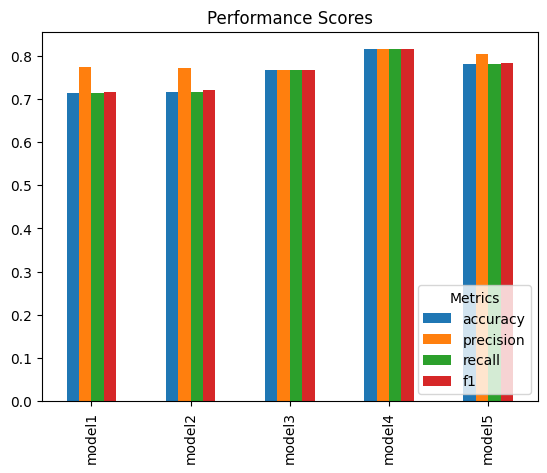

In [50]:
all_results.plot(kind='bar')
plt.legend(loc='lower right', title='Metrics')
plt.title('Performance Scores')

**Observations**:
- Model 4 outperformed Model 3, indicating that the generated features provided value/improved performance of the classifier and that the SME alone was not a sufficient predictor.

- Model 5 was a more complex network with more layers and nodes. It was better than the other models but did not out-perform Model 4.

,baseline,ml_gradientbooster
0,0.63,0.73
1,0.63,0.73


### Comparing results to the ML outcomes

It will be interesting to compare the scores to the ML outcomes.

**Updated**: The XGBooster Classifier was scored from a gridsearch performed on a fraction of the dataset, and therefore its results are not included in this frame. 

In [94]:
# adding the ML scores manually
complete_results = pd.concat([all_results['accuracy'], 
              pd.DataFrame({'ml_baseline': 0.63, 
                            'ml_gradientbooster':0.73,
                            # 'ml_xgbooster':0.83
                            }, index=[0]).T])
complete_results.rename(columns={0:'accuracy'},inplace=True)

In [95]:
complete_results

,accuracy
model1,0.713111
model2,0.716796
model3,0.766266
model4,0.814314
model5,0.779660
ml_baseline,0.630000
ml_gradientbooster,0.730000


Text(0.5, 1.0, 'Performance (ML and DL)')

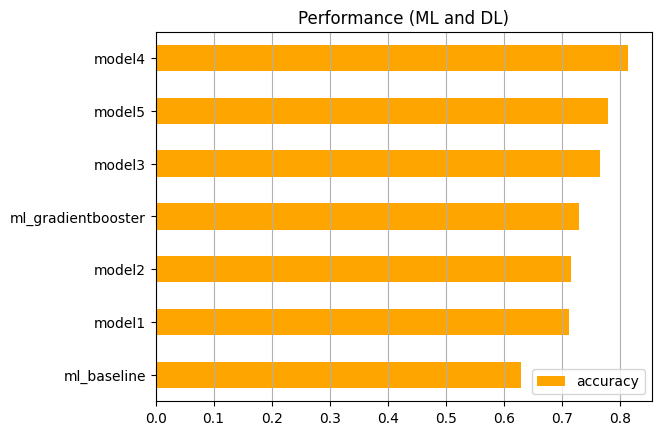

In [96]:
# visualizing the scores
complete_results.sort_values('accuracy').plot(kind='barh', color='orange')
plt.grid(axis='x')
plt.title('Performance (ML and DL)')